<a href="https://colab.research.google.com/github/zhangs22/radioml_edge_training/blob/main/rml2018_training_resnet_2blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import h5py
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt

In [ ]:
# Open the dataset
hdf5_file = h5py.File("RML2018.01a_block0.hdf5",  'r')

# Read the HDF5 groups
X_train = hdf5_file['X'][...]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1], -1)
Y_train = hdf5_file['Y'][...]
Z_train = hdf5_file['Z'][...]
hdf5_file.close()

print(type(X_train), type(Y_train), type(Z_train))
print(X_train.shape, Y_train.shape, Z_train.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(196608, 2, 1024, 1) (196608, 24) (196608, 1)


In [ ]:
# np.random.seed(2018)
# n_examples = int(10000 * 24)
# idx = np.random.choice(range(0,X.shape[0]), size=n_examples, replace=False)
# print(len(idx), idx)
# data = X[idx].reshape(n_examples, X.shape[2], X.shape[1], -1)
# lbl = Y[idx]
# snr = Z[idx]
# snrs = np.unique(snr)
# del X, Y, Z
# print(type(data), type(lbl), type(snr))
# print(data.shape, lbl.shape, snr.shape)

In [ ]:
# np.random.seed(2016)
# n_train = int(n_examples * 0.8)
# train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)
# test_idx = list(set(range(0,n_examples))-set(train_idx))
# X_train = data[train_idx]
# X_test =  data[test_idx]
# Y_train = lbl[train_idx]
# Y_test =  lbl[test_idx]
# Z_train = snr[train_idx]
# Z_test =  snr[test_idx]
print(np.unique(Y_train, axis=0).shape[0] == 24)
print(np.unique(Z_train))
# print(np.unique(Y_test, axis=0).shape[0] == 24)
# print(np.unique(Z_test))

True
[-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]


In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', 
           '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 
           'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']
print(classes)

(196608, 2, 1024, 1) [2, 1024, 1]
['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']


In [ ]:
def residual_unit(input_tensor, filters, kernel_size):
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(x)
    x = layers.Activation('linear')(x)
    # skip connection
    if x.shape[1:] == input_tensor.shape[1:]:
        x = layers.Add()([x, input_tensor])
    else:
        raise Exception('Skip Connection Failure!')
    return x

def residual_stack(input_tensor, filters):
    x = layers.Conv2D(filters=filters, kernel_size=(1, 1), padding="same")(input_tensor)
    x = layers.Activation('linear')(x)
    x = residual_unit(x, filters, (1, 3))
    x = residual_unit(x, filters, (1, 3))
    x = layers.MaxPooling2D((1, 2))(x)
    return x

In [ ]:
def ResNet(input_shape, classes):   
    # create input tensor
    x_input = layers.Input(input_shape)
    x = x_input
    # residual stack
    num_filters = 32
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    
    # output layer
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = layers.Dropout(.5)(x)
    x = layers.Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = layers.Dropout(.5)(x)
    x = layers.Dense(classes , activation='softmax', kernel_initializer = glorot_uniform(seed=0))(x)
    
    # Create model
    model = Model(x_input, x)
    return model

# adm = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model = ResNet(in_shp, len(classes))
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 1024, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 2, 1024, 32)  64          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 2, 1024, 32)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2, 1024, 32)  3104        activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
history = model.fit(X_train, Y_train, batch_size=batch_size, verbose=2, epochs=nb_epoch, validation_split=0.1)

Epoch 1/100
173/173 - 68s - loss: 2.9516 - accuracy: 0.1351 - val_loss: 2.2364 - val_accuracy: 0.2501
Epoch 2/100
173/173 - 21s - loss: 2.2200 - accuracy: 0.2513 - val_loss: 2.0245 - val_accuracy: 0.3046
Epoch 3/100
173/173 - 22s - loss: 2.0416 - accuracy: 0.3020 - val_loss: 1.8868 - val_accuracy: 0.3528
Epoch 4/100
173/173 - 21s - loss: 1.9461 - accuracy: 0.3340 - val_loss: 1.8990 - val_accuracy: 0.3387
Epoch 5/100
173/173 - 21s - loss: 1.8833 - accuracy: 0.3525 - val_loss: 1.8511 - val_accuracy: 0.3525
Epoch 6/100
173/173 - 22s - loss: 1.8263 - accuracy: 0.3721 - val_loss: 1.7693 - val_accuracy: 0.3947
Epoch 7/100
173/173 - 22s - loss: 2.4941 - accuracy: 0.2602 - val_loss: 1.9650 - val_accuracy: 0.3219
Epoch 8/100
173/173 - 22s - loss: 1.9576 - accuracy: 0.3222 - val_loss: 1.8570 - val_accuracy: 0.3552
Epoch 9/100
173/173 - 21s - loss: 1.8844 - accuracy: 0.3449 - val_loss: 1.8214 - val_accuracy: 0.3645
Epoch 10/100
173/173 - 20s - loss: 1.8537 - accuracy: 0.3557 - val_loss: 1.7998 - 

Epoch 81/100
173/173 - 21s - loss: 1.2942 - accuracy: 0.5668 - val_loss: 1.5003 - val_accuracy: 0.5169
Epoch 82/100
173/173 - 21s - loss: 1.2921 - accuracy: 0.5666 - val_loss: 1.5064 - val_accuracy: 0.5236
Epoch 83/100
173/173 - 21s - loss: 1.2893 - accuracy: 0.5684 - val_loss: 1.4954 - val_accuracy: 0.5211
Epoch 84/100
173/173 - 21s - loss: 1.2917 - accuracy: 0.5680 - val_loss: 1.5459 - val_accuracy: 0.5088
Epoch 85/100
173/173 - 21s - loss: 1.2921 - accuracy: 0.5667 - val_loss: 1.5053 - val_accuracy: 0.5217
Epoch 86/100
173/173 - 21s - loss: 1.2844 - accuracy: 0.5693 - val_loss: 1.4935 - val_accuracy: 0.5234
Epoch 87/100
173/173 - 21s - loss: 1.2792 - accuracy: 0.5701 - val_loss: 1.4993 - val_accuracy: 0.5211
Epoch 88/100
173/173 - 21s - loss: 1.2787 - accuracy: 0.5716 - val_loss: 1.5247 - val_accuracy: 0.5151
Epoch 89/100
173/173 - 21s - loss: 1.2778 - accuracy: 0.5713 - val_loss: 1.5122 - val_accuracy: 0.5249
Epoch 90/100
173/173 - 21s - loss: 1.2733 - accuracy: 0.5737 - val_loss: 

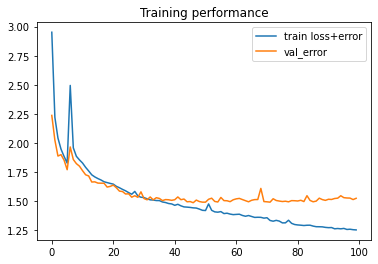

In [ ]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [ ]:
# Open the dataset
hdf5_file = h5py.File("RML2018.01a_block1.hdf5",  'r')

# Read the HDF5 groups
X_train = hdf5_file['X'][...]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1], -1)
Y_train = hdf5_file['Y'][...]
Z_train = hdf5_file['Z'][...]
hdf5_file.close()

print(type(X_train), type(Y_train), type(Z_train))
print(X_train.shape, Y_train.shape, Z_train.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(196608, 2, 1024, 1) (196608, 24) (196608, 1)


In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
history = model.fit(X_train, Y_train, batch_size=batch_size, verbose=2, epochs=nb_epoch, validation_split=0.1)

Epoch 1/100
173/173 - 20s - loss: 1.4825 - accuracy: 0.5150 - val_loss: 1.4104 - val_accuracy: 0.5337
Epoch 2/100
173/173 - 21s - loss: 1.4183 - accuracy: 0.5335 - val_loss: 1.3953 - val_accuracy: 0.5373
Epoch 3/100
173/173 - 21s - loss: 1.4014 - accuracy: 0.5389 - val_loss: 1.3951 - val_accuracy: 0.5384
Epoch 4/100
173/173 - 22s - loss: 1.3934 - accuracy: 0.5400 - val_loss: 1.3995 - val_accuracy: 0.5365
Epoch 5/100
173/173 - 21s - loss: 1.3851 - accuracy: 0.5440 - val_loss: 1.3854 - val_accuracy: 0.5412
Epoch 6/100
173/173 - 20s - loss: 1.3773 - accuracy: 0.5470 - val_loss: 1.3933 - val_accuracy: 0.5371
Epoch 7/100
173/173 - 20s - loss: 1.3727 - accuracy: 0.5492 - val_loss: 1.3839 - val_accuracy: 0.5400
Epoch 8/100
173/173 - 20s - loss: 1.4420 - accuracy: 0.5259 - val_loss: 1.4616 - val_accuracy: 0.5102
Epoch 9/100
173/173 - 20s - loss: 1.4089 - accuracy: 0.5339 - val_loss: 1.4039 - val_accuracy: 0.5341
Epoch 10/100
173/173 - 20s - loss: 1.3772 - accuracy: 0.5466 - val_loss: 1.3749 - 

Epoch 81/100
173/173 - 20s - loss: 1.1588 - accuracy: 0.6232 - val_loss: 1.4930 - val_accuracy: 0.5494
Epoch 82/100
173/173 - 20s - loss: 1.1601 - accuracy: 0.6217 - val_loss: 1.4721 - val_accuracy: 0.5517
Epoch 83/100
173/173 - 20s - loss: 1.1649 - accuracy: 0.6196 - val_loss: 1.4890 - val_accuracy: 0.5514
Epoch 84/100
173/173 - 20s - loss: 1.1557 - accuracy: 0.6231 - val_loss: 1.4710 - val_accuracy: 0.5572
Epoch 85/100
173/173 - 20s - loss: 1.1550 - accuracy: 0.6236 - val_loss: 1.4850 - val_accuracy: 0.5544
Epoch 86/100
173/173 - 20s - loss: 1.1465 - accuracy: 0.6254 - val_loss: 1.4818 - val_accuracy: 0.5548
Epoch 87/100
173/173 - 20s - loss: 1.1490 - accuracy: 0.6252 - val_loss: 1.4972 - val_accuracy: 0.5524
Epoch 88/100
173/173 - 20s - loss: 1.1498 - accuracy: 0.6245 - val_loss: 1.5028 - val_accuracy: 0.5455
Epoch 89/100
173/173 - 20s - loss: 1.1494 - accuracy: 0.6252 - val_loss: 1.4932 - val_accuracy: 0.5521
Epoch 90/100
173/173 - 21s - loss: 1.1466 - accuracy: 0.6260 - val_loss: 

In [ ]:
# Open the dataset
hdf5_file = h5py.File("RML2018.01a_block12.hdf5",  'r')

# Read the HDF5 groups
X_test = hdf5_file['X'][...]
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1], -1)
Y_test = hdf5_file['Y'][...]
Z_test = hdf5_file['Z'][...]
hdf5_file.close()

print(type(X_test), type(Y_test), type(Z_test))
print(X_test.shape, Y_test.shape, Z_test.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(196608, 2, 1024, 1) (196608, 24) (196608, 1)


In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.484869360923767
Test accuracy: 0.558624267578125


In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

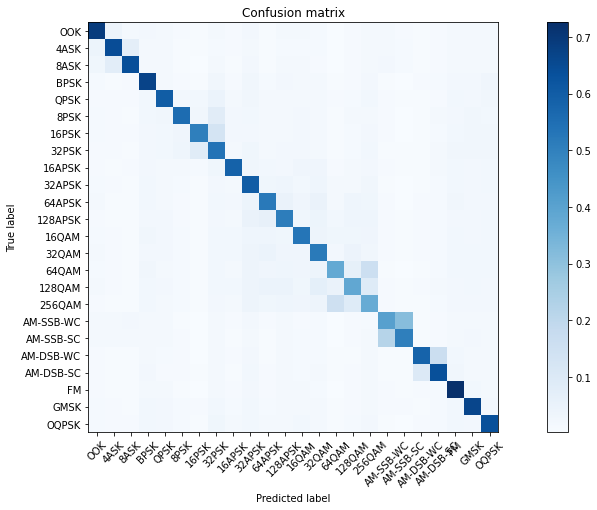

In [ ]:
plt.rcParams['figure.figsize'] = [14, 7]
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.04060646011865524
Overall Accuracy:  0.04269013529489032
Overall Accuracy:  0.04381408975895592
Overall Accuracy:  0.044207723035952065
Overall Accuracy:  0.042140468227424746
Overall Accuracy:  0.04935200942531745
Overall Accuracy:  0.06238336443615036
Overall Accuracy:  0.10899328859060403
Overall Accuracy:  0.2385806964120217
Overall Accuracy:  0.3411530815109344
Overall Accuracy:  0.44803389381702635
Overall Accuracy:  0.5623116236404141
Overall Accuracy:  0.6601108764519535
Overall Accuracy:  0.7763582571274878
Overall Accuracy:  0.8616243519872391
Overall Accuracy:  0.9106100795755968
Overall Accuracy:  0.9139028920137967
Overall Accuracy:  0.9234987661091308
Overall Accuracy:  0.9321725571725572
Overall Accuracy:  0.9227393617021277


/home/zs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Overall Accuracy:  0.9334459898609125
Overall Accuracy:  0.9273430209305425
Overall Accuracy:  0.9299337748344371
Overall Accuracy:  0.9281832298136646
Overall Accuracy:  0.9280229077183392
Overall Accuracy:  0.9262073406310367


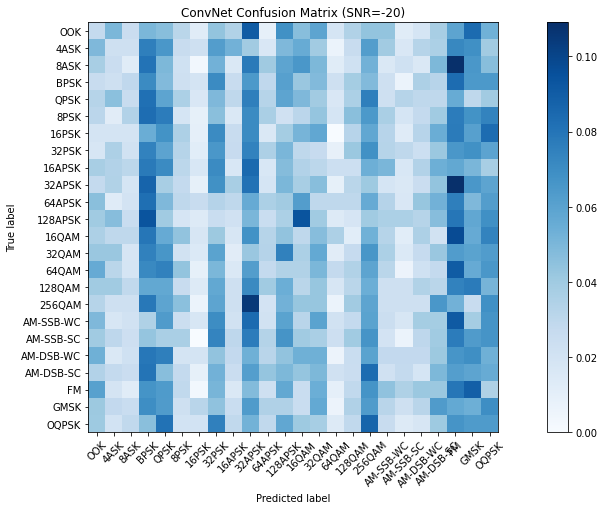

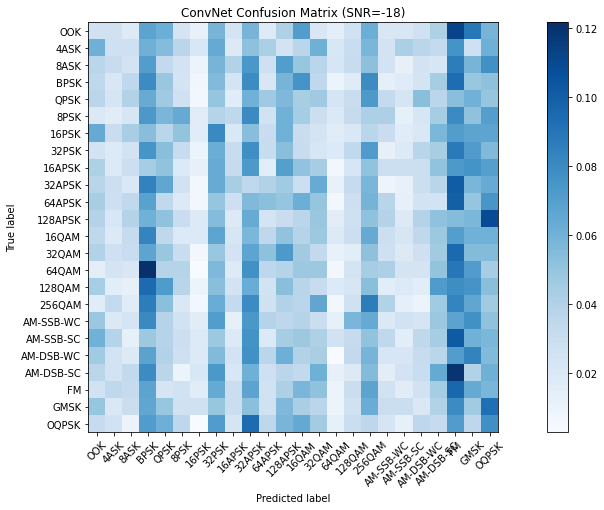

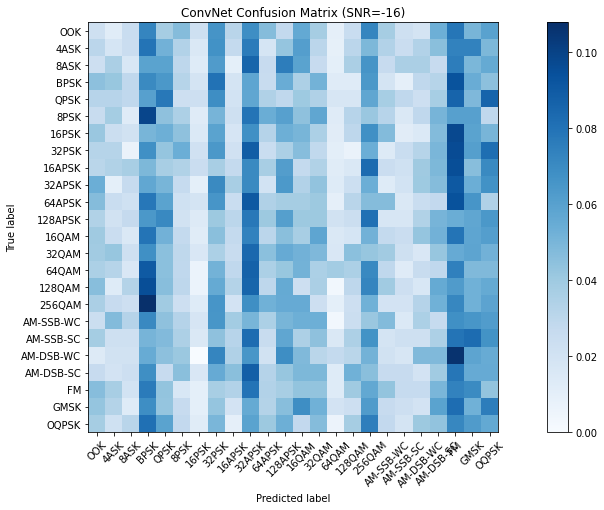

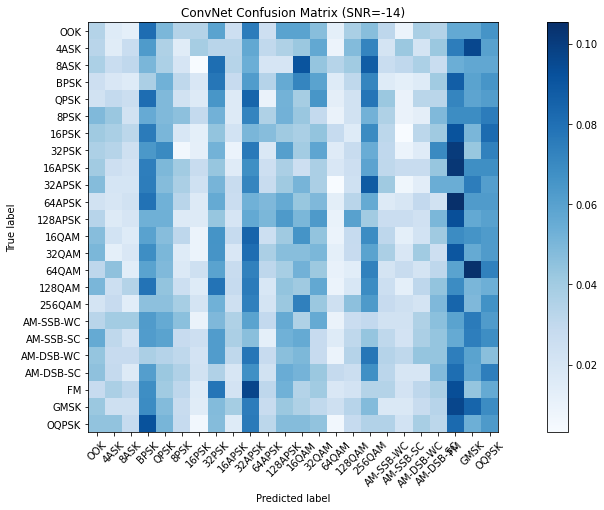

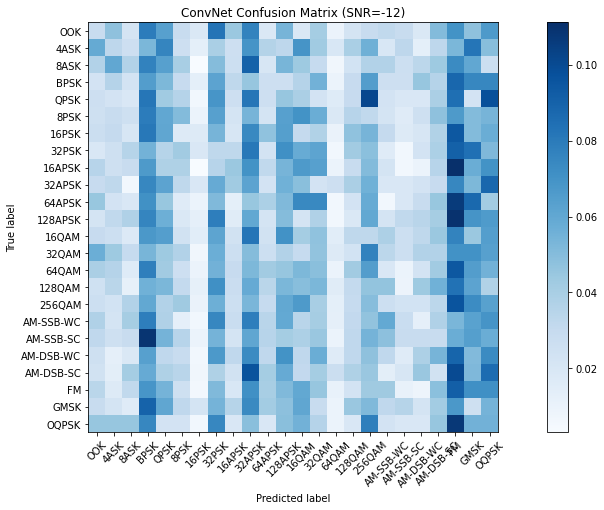

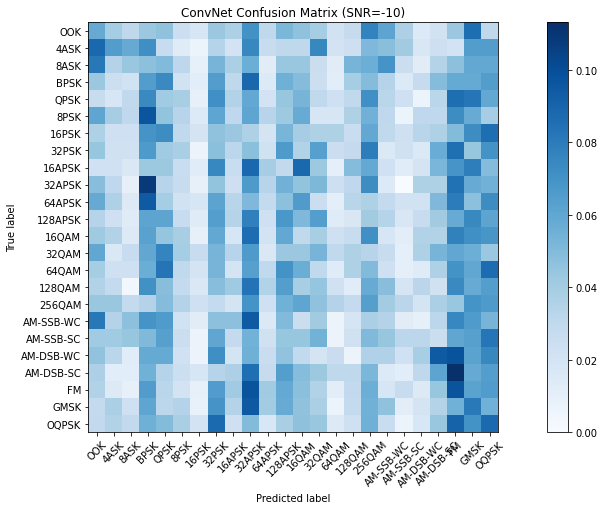

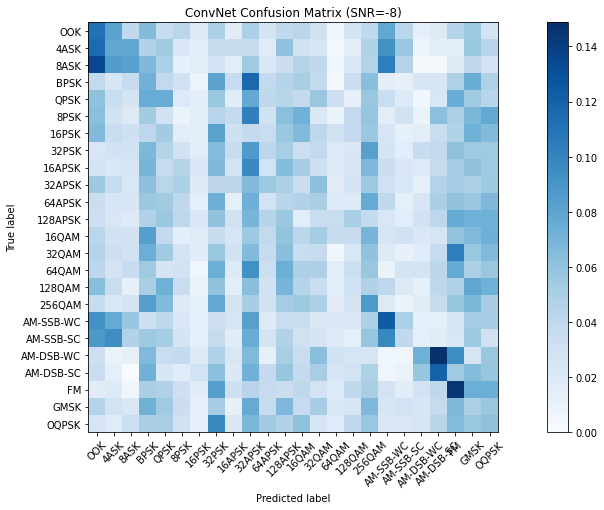

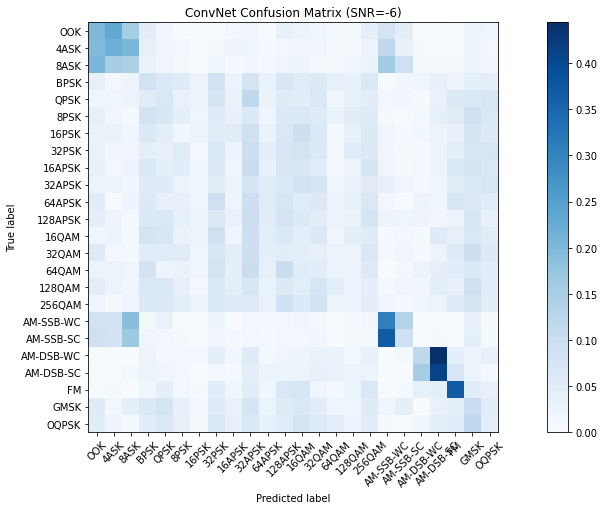

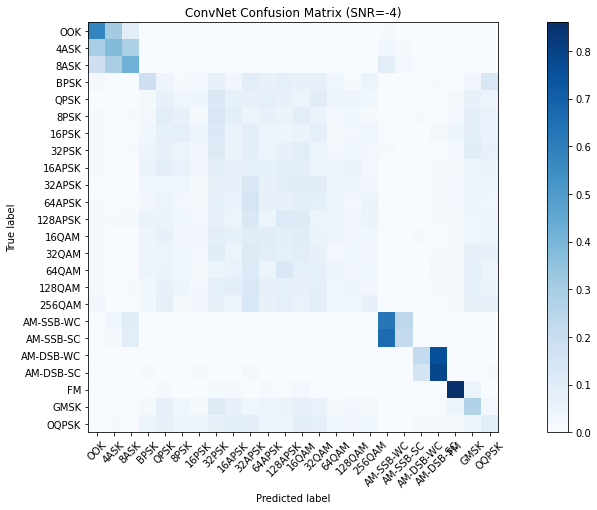

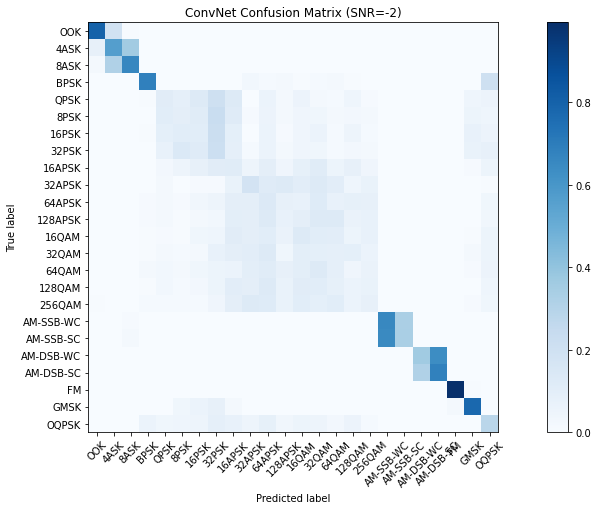

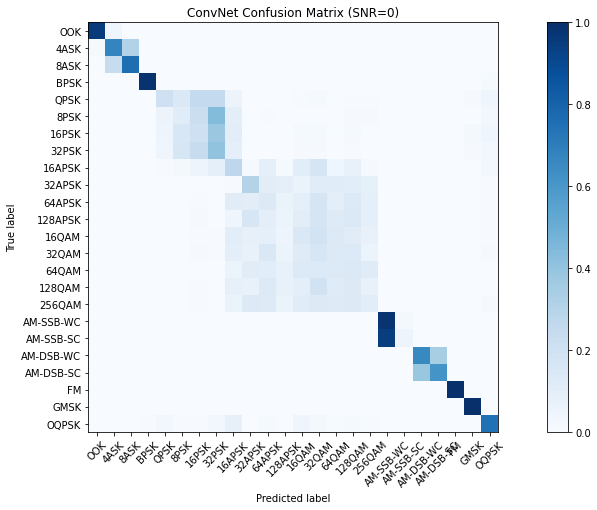

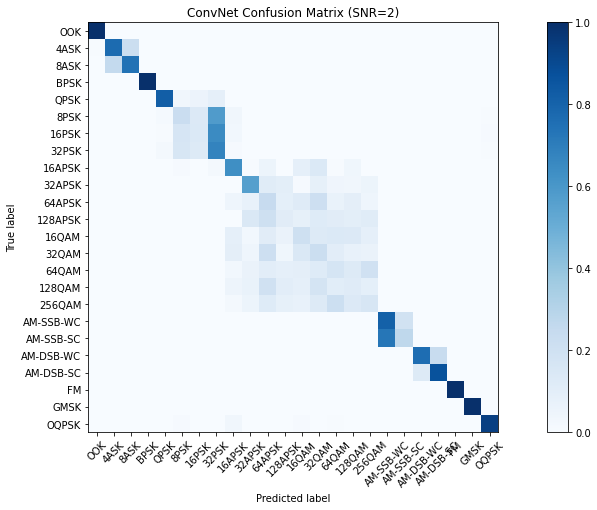

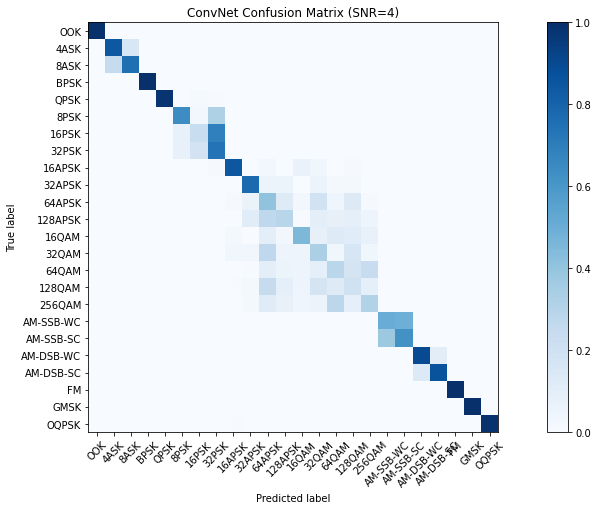

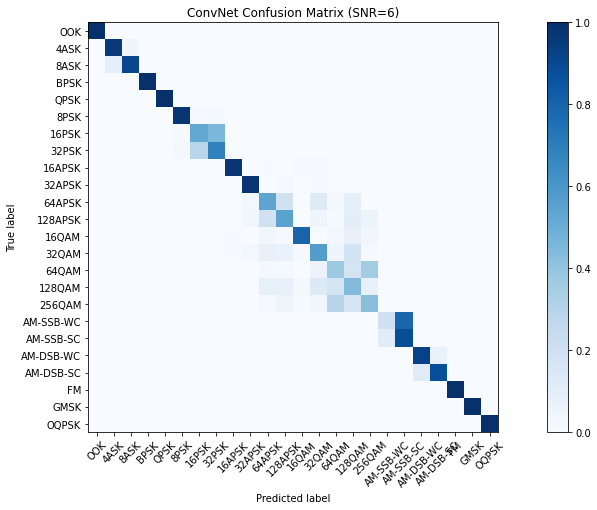

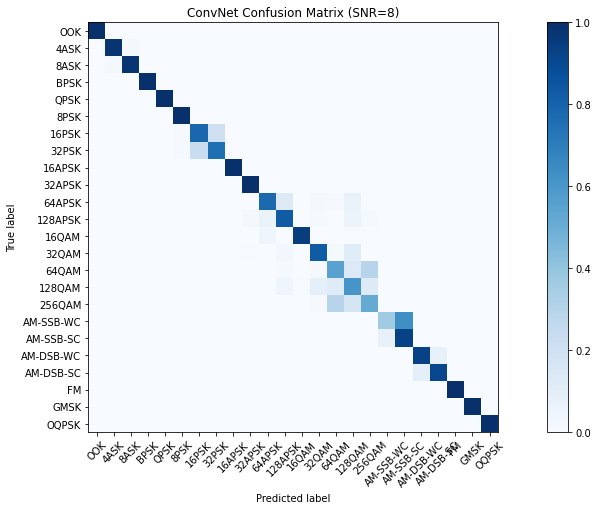

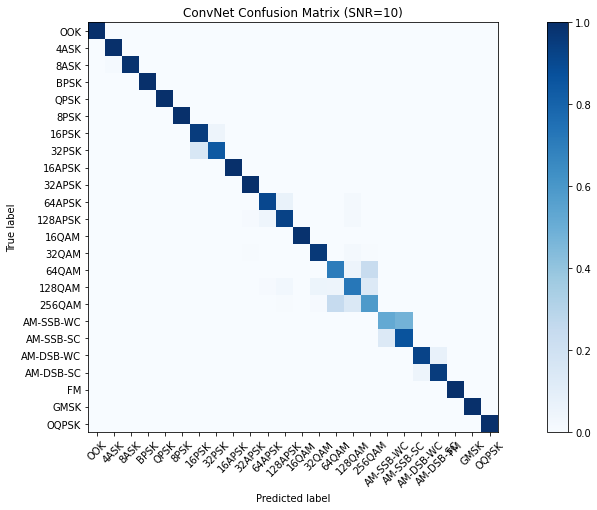

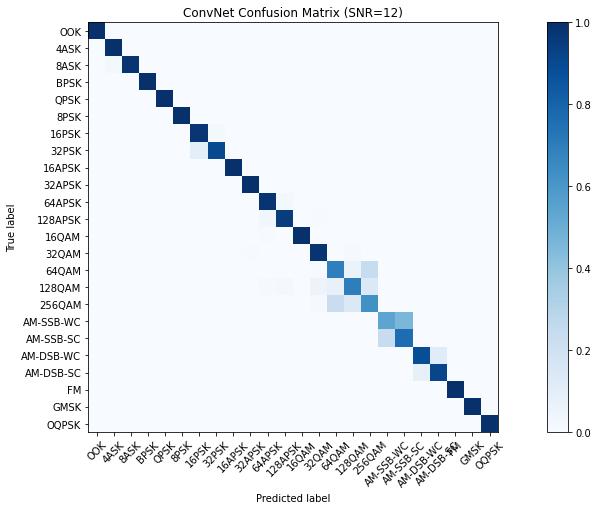

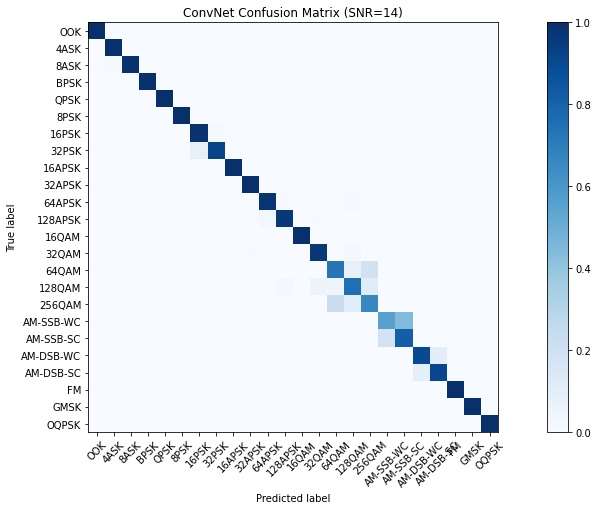

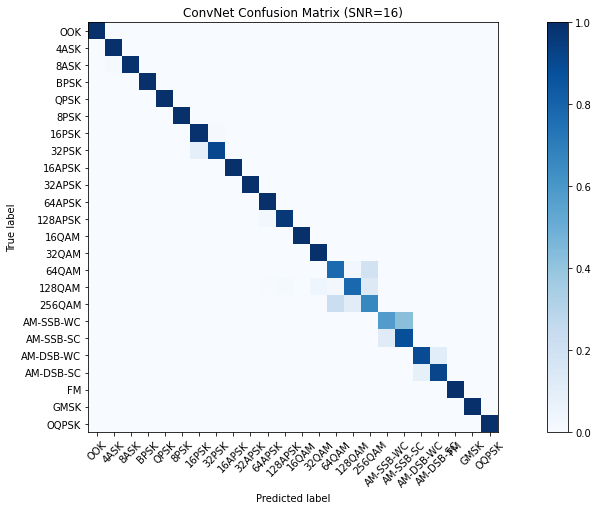

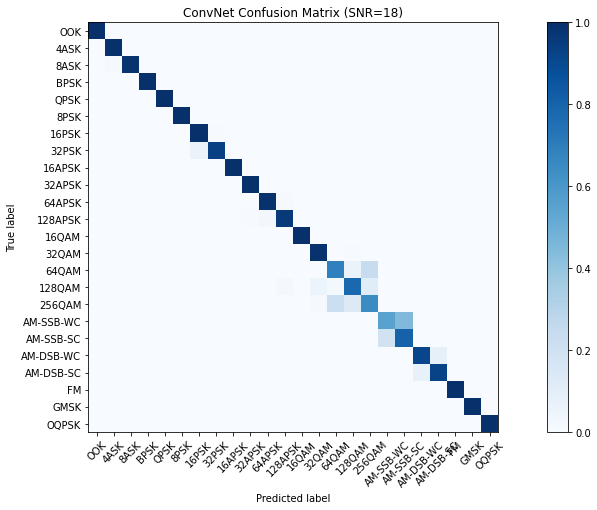

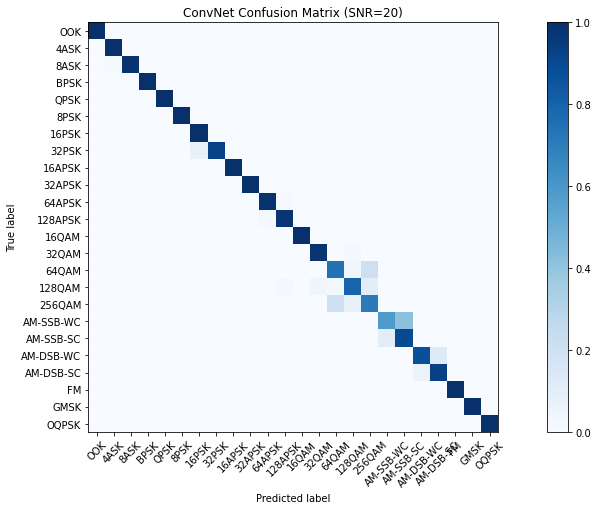

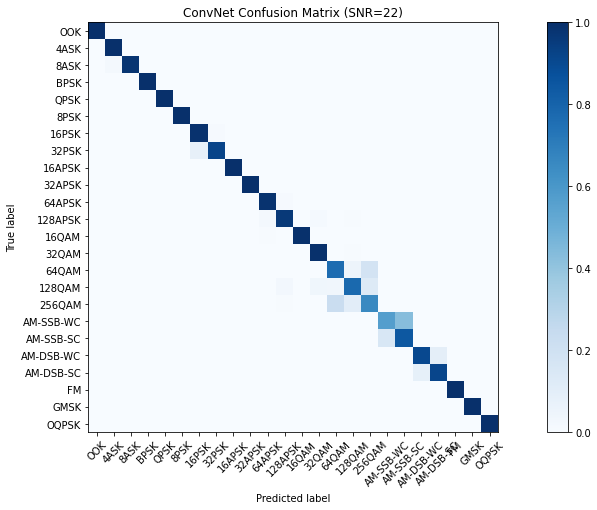

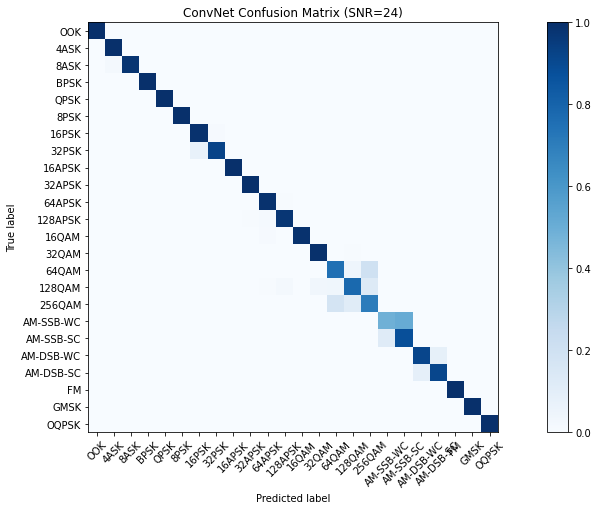

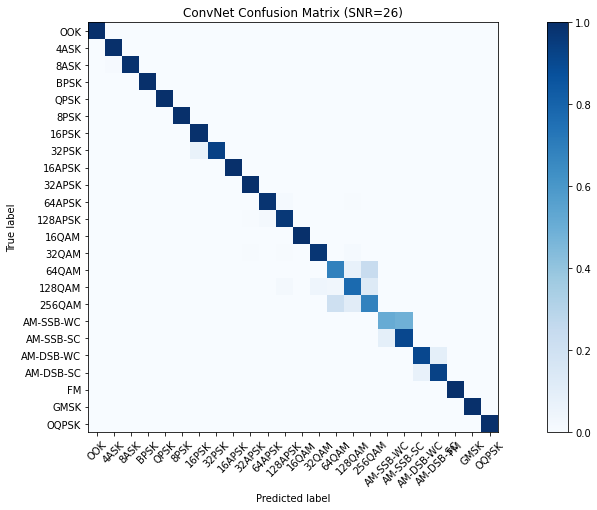

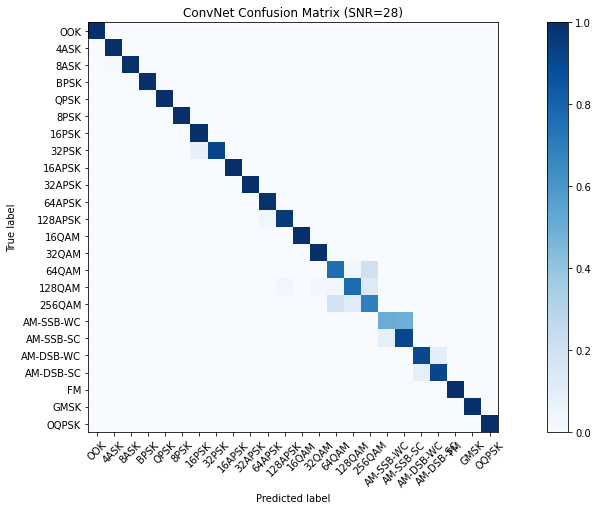

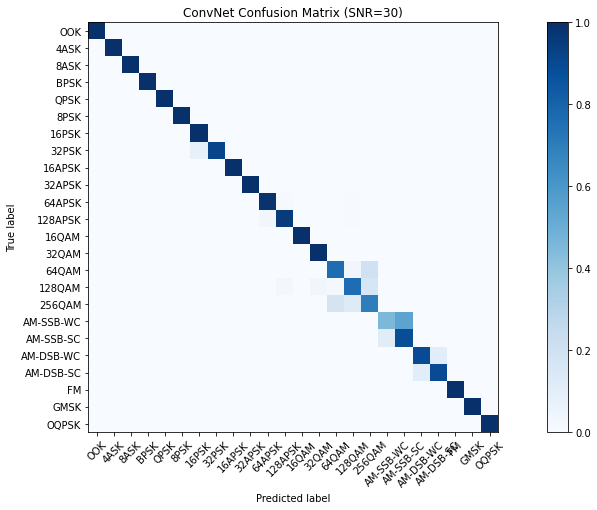

In [ ]:
# Plot confusion matrix
acc = {}
snr = Z_test
snrs = np.unique(snr)
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = Z_test[:, 0]
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    
#     print(snr)
#     print(test_SNRs)
#     print(np.where(test_SNRs==snr))
#     print(X_test.shape, Y_test.shape)
#     print(test_X_i.shape, test_Y_i.shape)
    
#     break
    
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2018.01 Alpha')

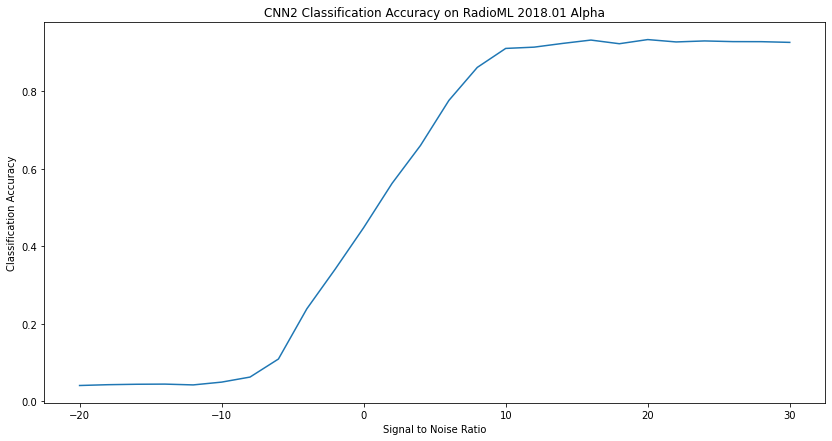

In [ ]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2018.01 Alpha")